# Ship Identification Based on Satellite imagery


---






## Check out GPU


We want to see a P100 present so things run smoothly within 12 hours

In [ ]:
!nvidia-smi

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  CUDA_VERSION="cu101"
else:
  print('Not running on CoLab')
  CUDA_VERSION="cu110"

Wed Jan  6 20:31:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



## Installation and setup (reload runtime first time)
Lets install our libraries. 
This will crash - simply because the runtime needs restarting with Pyyaml before detectron2 can be installed, so don't worry, just keep going!

This is also pulling in the HRSC dataset from Kaggle, please enter your kaggle ID and passcode here. 

In [ ]:
# General dependencies
!pip install -q scipy
!pip install -q cython
# !pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' 
!pip install -q kaggle pyunpack patool opencv-python pillow elementpath
# !apt install -q python-opencv -y

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 133kB 11.9MB/s 


In [ ]:
# install Pytorch
!pip install -q torch==1.7.0+$CUDA_VERSION torchvision==0.8.1+$CUDA_VERSION torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 7.6MB 6.6MB/s 


In [ ]:
# install detectron2 dependencies: 
!pip install -q pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

# print(detectron2.utils.collect_env.collect_env_info())

     |████████████████████████████████| 276kB 7.9MB/s 
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 4.7MB/s 
     |████████████████████████████████| 2.2MB 9.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201218-cp36-none-any.whl size=40701 sha256=a193ecd440c0609521ae95f43d6aa06be9dcaf71e5d932e01e5f76ff6504df37
  Stored in directory: /root/.cache/pip/wheels/b5/83/3f/e74a72d264351b5ada512da845a5c6abb81a34f6333c3a54ce
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10508 sha256=567b778835bfccfa593a16f2451fff029aa374976a09023b0fb05766271cf483
  Stored in directory: /root/.cache/pip/wheels/9e/01/e4/1b68f

In [ ]:
import os
ROOT_DIR = "/mnt/My Drive/datasets/" # Root directory for all datasets

# You can download dataset from this share or let it get downloaded from kaggle (with outputs)
# https://drive.google.com/drive/folders/11XK4OQ9gxcBnQUpD5J6w-xuK7vhynsVz?usp=sharing

dataset_path = os.path.join(ROOT_DIR, "HRSC2016") # folder where dataset is stored
if not os.path.exists("/mnt/My Drive"):
  print("Drive not mounted yet")
  from google.colab import drive
  drive.mount('/mnt')


Drive not mounted yet
Mounted at /mnt


## Imports

In [ ]:
import detectron2
import contextlib
import datetime
import io
import os
import json
import logging
import cv2
import random
import numpy as np
import copy,torch,torchvision
import PIL
from PIL import Image
import xml.etree.ElementTree as X
import math
from itertools import repeat

from fvcore.common.file_io import PathManager
from fvcore.common.timer import Timer

from detectron2.structures import Boxes, BoxMode, PolygonMasks
from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import RotatedCOCOEvaluator,DatasetEvaluators, inference_on_dataset, coco_evaluation,DatasetEvaluator
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import matplotlib.pyplot as plt

import glob
import time
import shutil
from multiprocessing.pool import ThreadPool
import concurrent.futures
from pyunpack import Archive

import torch
torch.cuda.set_device(0)

setup_logger()

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



<Logger detectron2 (DEBUG)>

## Download kaggle data
First check if data exists in mounted personal Gdrive, if not, download it locally

In [ ]:
# Note: This organization of this dataset is horrific

KaggleUserName = "stevemadner" 
KaggleKey = "b2bd83ca26e135422aeac87156d492fd" 

if not os.path.exists(dataset_path):
  # download_path = os.path.join(ROOT_DIR, "tmp")
  download_path = "/tmp/HRSC"
  print("Dataset not found, downloading to " + download_path)

  os.environ['KAGGLE_USERNAME']=KaggleUserName
  os.environ['KAGGLE_KEY']=KaggleKey

  import kaggle
  kaggle.api.authenticate()
  kaggle.api.dataset_download_files('guofeng/hrsc2016', path=download_path, unzip=True, quiet=False)

  print("Extracting to " + ROOT_DIR)
  archives=[i for i in glob.glob(os.path.join(download_path, 'hrsc2016_dataset', 'HRSC2016.part*.rar'))]
  with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
      list(executor.submit(Archive(name).extractall, ROOT_DIR) for name in archives)
      print("Extraction thread done")

  print("All datasets extracted, removing " + download_path)
  try:
    # shutil.rmtree(download_path)
    pass
  except:
    print("Error while deleting tmp directory")
else:
  print("Dataset found in " + dataset_path)

Dataset found in /mnt/My Drive/datasets/HRSC2016


## Modifications for rotation
### Custom mapper
https://github.com/facebookresearch/detectron2/issues/21#issuecomment-595522318

```utils.transform_instance_annotations``` does not work for rotated boxes and you need a custom version using ```transform.apply_rotated_box```

```utils.annotations_to_instances``` needs to be replaced by ```utils.annotations_to_instances_rotated```


In [ ]:
def my_transform_instance_annotations(annotation, transforms, image_size, *, keypoint_hflip_indices=None):
  if annotation["bbox_mode"] == BoxMode.XYWHA_ABS:
    annotation["bbox"] = transforms.apply_rotated_box(np.asarray([annotation["bbox"]]))[0]
  else:
    bbox = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
    # Note that bbox is 1d (per-instance bounding box)
    annotation["bbox"] = transforms.apply_box([bbox])[0]
    annotation["bbox_mode"] = BoxMode.XYXY_ABS

  return annotation

def mapper(dataset_dict):
  # Implement a mapper, similar to the default DatasetMapper, but with our own customizations
  dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
  image = utils.read_image(dataset_dict["file_name"], format="BGR")
  image, transforms = T.apply_transform_gens([T.Resize((800, 800))], image)
  dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

  annos = [
      my_transform_instance_annotations(obj, transforms, image.shape[:2]) 
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
  ]
  instances = utils.annotations_to_instances_rotated(annos, image.shape[:2])
  dataset_dict["instances"] = utils.filter_empty_instances(instances)
  return dataset_dict



In [ ]:
class MyTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name):
      output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
      evaluators = [RotatedCOCOEvaluator(dataset_name, cfg, True, output_folder)]
      return DatasetEvaluators(evaluators)
      
  @classmethod
  def build_train_loader(cls, cfg):
      return build_detection_train_loader(cfg, mapper=mapper)

class RotatedPredictor(DefaultPredictor):
    def __init__(self, cfg):
        
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = trainer.model
        self.model.eval()

        self.transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.transform_gen.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

# As of 0.3 the XYWHA_ABS box is not supported in the visualizer, this is fixed in master branch atm (19/11/20)
class myVisualizer(Visualizer):
  
    def draw_dataset_dict(self, dic):
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYWHA_ABS) for x in annos]

            labels = [x["category_id"] for x in annos]
            names = self.metadata.get("thing_classes", None)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances(labels=labels, boxes=boxes, masks=masks, keypoints=keypts)

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            sem_seg = cv2.imread(dic["sem_seg_file_name"], cv2.IMREAD_GRAYSCALE)
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output

## Handle annotations
Here we're going to generate the annotations from the dataset. HRSC2016 was written in caffe and has many tools written in C. Therefore they're not natively COCO compatible.

In [ ]:
metaclasses_simple = {'100000001': 'ship',
             '100000002': 'aircraft carrier',
             '100000003': 'warcraft',
             '100000004': 'merchant ship',
             '100000005': 'aircraft carrier',
             '100000006': 'aircraft carrier',
             '100000007': 'destroyer',
             '100000008': 'warcraft',
             '100000009': 'destroyer',
             '100000010': 'amphibious',
             '100000011': 'cruiser',
             '100000012': 'aircraft carrier',
             '100000013': 'aircraft carrier',
             '100000014': 'destroyer',
             '100000015': 'amphibious',
             '100000016': 'amphibious',
             '100000017': 'amphibious',
             '100000018': 'merchant ship',
             '100000019': 'merchant ship',
             '100000020': 'merchant ship',
             '100000022': 'Hovercraft',
             '100000024': 'ship',
             '100000025': 'merchant ship',
             '100000026': 'ship',
             '100000027': 'submarine',
             '100000028': 'ship',
             '100000029': 'ship',
             '100000030': 'merchant ship',
             '100000031': 'aircraft carrier',
             '100000032': 'aircraft carrier',
             '100000033': 'aircraft carrier'}

metaclasses_extensive = {'100000001': 'ship',
              '100000002': 'aircraft carrier',
              '100000003': 'warcraft',
              '100000004': 'merchant ship',
              '100000005': 'Nimitz class aircraft carrier',
              '100000006': 'Enterprise class aircraft carrier',
              '100000007': 'Arleigh Burke class destroyers',
              '100000008': 'WhidbeyIsland class landing craft',
              '100000009': 'Perry class frigate',
              '100000010': 'Sanantonio class amphibious transport dock',
              '100000011': 'Ticonderoga class cruiser',
              '100000012': 'Kitty Hawk class aircraft carrier',
              '100000013': 'Admiral Kuznetsov aircraft carrier',
              '100000014': 'Abukuma-class destroyer escort',
              '100000015': 'Austen class amphibious transport dock',
              '100000016': 'Tarawa-class amphibious assault ship',
              '100000017': 'USS Blue Ridge (LCC-19)',
              '100000018': 'Container ship',
              '100000019': 'OXo|--)',
              '100000020': 'Car carrier([]==[])',
              '100000022': 'Hovercraft',
              '100000024': 'yacht',
              '100000025': 'Container ship(_|.--.--|_]=',
              '100000026': 'Cruise ship',
              '100000027': 'submarine',
              '100000028': 'lute',
              '100000029': 'Medical ship',
              '100000030': 'Car carrier(======|',
              '100000031': 'Ford-class aircraft carriers',
              '100000032': 'Midway-class aircraft carrier',
              '100000033': 'Invincible-class aircraft carrier'}

used_classes = metaclasses_simple
# used_classes = metaclasses_extensive

class_name_list = list(set(used_classes.values())) # list of all unique classes
class_id_dict = {} # index of each class by ID
for key, name in used_classes.items():
  class_id_dict.update({key: class_name_list.index(name)})
  

## Dataset preperation

In [ ]:
def get_file_record(file_id, set_folder="Train") :
  #open file xml
  xml_path = os.path.join(dataset_path, set_folder, 'Annotations', file_id+".xml")
  img_path = os.path.join(dataset_path, set_folder, 'AllImages', file_id+'.bmp')

  # check if Annotation exists and img file exists
  if not os.path.isfile(xml_path) or not os.path.isfile(img_path):
    return

  tree = X.parse(xml_path)
  root = tree.getroot()

  record = {}
  #store our file data
  record["file_name"] = img_path
  record["image_id"] = int(root.find("Img_FileName").text)
  record["height"] = int(root.find("Img_SizeHeight").text)
  record["width"] =  int(root.find("Img_SizeWidth").text)

  objs = []
  for anno in root.findall("HRSC_Objects/HRSC_Object"):
    x1=int(anno.findtext("box_xmin"))
    x2=int(anno.findtext("box_xmax"))
    y1=int(anno.findtext("box_ymin"))
    y2=int(anno.findtext("box_ymax"))
    a=-math.degrees(float(anno.findtext("mbox_ang")))
    cx=float(anno.findtext("mbox_cx"))
    cy=float(anno.findtext("mbox_cy"))
    w=float(anno.findtext("mbox_w"))
    h=float(anno.findtext("mbox_h"))
    obj = {
      "bbox": [cx,cy,w,h,a],
      "bbox_mode": BoxMode.XYWHA_ABS,
      "category_id": class_id_dict[anno.find("Class_ID").text]
      }
    objs.append(obj)
  record["annotations"] = objs
  return record

def get_dataset(dir):
  base_path = os.path.join(dataset_path, dir)
  sysdata_path = os.path.join(base_path, 'sysdata.xml')

  root = X.parse(sysdata_path).getroot()

  dataset_dicts = []
  for id in root.findall("HRSC_DataSet_Exp/HRSC_DSExpImgs/HRSC_DataSet_Exp_Group/ExpGroup_Imgs/Img_NO"):
    file_id = id.text
    record = get_file_record(file_id, dir)
    if record is not None:
      dataset_dicts.append(record)

  return dataset_dicts

DatasetCatalog.clear()
MetadataCatalog.clear()
for d in ["Train", "Test"]:
  DatasetCatalog.register(d, lambda d=d: get_dataset(d))
  MetadataCatalog.get(d).set(thing_classes=class_name_list)

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



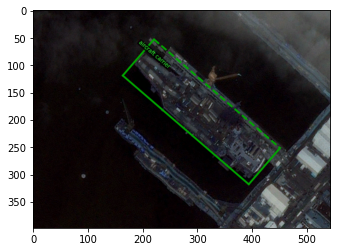

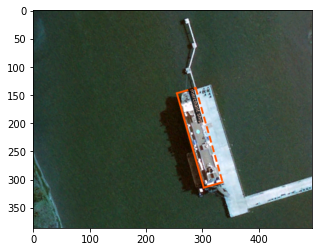

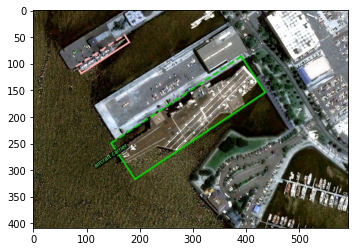

In [ ]:
dataset_dicts = get_dataset("Train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = myVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("Train"), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()



In [ ]:
d

{'annotations': [{'bbox': [582.2309,
    404.3464,
    586.8726,
    162.2496,
    33.688646387387216],
   'bbox_mode': <BoxMode.XYWHA_ABS: 4>,
   'category_id': 1},
  {'bbox': [262.5479, 166.0378, 214.8692, 31.84549, 33.07016709543325],
   'bbox_mode': <BoxMode.XYWHA_ABS: 4>,
   'category_id': 4}],
 'file_name': '/mnt/My Drive/datasets/HRSC2016/Train/AllImages/100001536.bmp',
 'height': 818,
 'image_id': 100001536,
 'width': 1186}

## Setup configuration
Now we've got out data in a usable form,and some useful functions lets configure our tests. below are the options for training, 

In [ ]:
cfg = get_cfg()

cfg.OUTPUT_DIR = os.path.join(dataset_path, 'output')

#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # Let training initialize from model zoo
cfg.DATASETS.TRAIN = (["Train"])
cfg.DATASETS.TEST = (["Test"])

cfg.MODEL.MASK_ON=False
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
cfg.MODEL.RPN.HEAD_NAME = "StandardRPNHead"
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ANCHOR_GENERATOR.NAME = "RotatedAnchorGenerator"
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90,-60,-30,0,30,60,90]]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 
cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #this is far lower than usual.  
cfg.MODEL.ROI_HEADS.NUM_CLASSES =len(class_name_list)
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ROI_BOX_HEAD.NUM_CONV=4
cfg.MODEL.ROI_MASK_HEAD.NUM_CONV=8
cfg.SOLVER.IMS_PER_BATCH = 15 #can be up to  24 for a p100 (6 default)
cfg.SOLVER.CHECKPOINT_PERIOD=1500
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.GAMMA=0.5
cfg.SOLVER.STEPS=[1000,2000,4000,8000, 12000]
cfg.SOLVER.MAX_ITER=14000


cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True 
cfg.DATALOADER.SAMPLER_TRAIN= "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD=0.01
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)#lets just check our output dir exists
cfg.MODEL.BACKBONE.FREEZE_AT=6


# Notes on how to implement:
# https://github.com/facebookresearch/detectron2/issues/21#issuecomment-595522318
# MODEL:
#   ANCHOR_GENERATOR:
#     NAME: RotatedAnchorGenerator
#     ANGLES: [[-90,-60,-30,0,30,60,90]]
#   PROPOSAL_GENERATOR:
#     NAME: RRPN
#   RPN:
#     BBOX_REG_WEIGHTS: (1,1,1,1,1)
#   ROI_BOX_HEAD:
#     POOLER_TYPE: ROIAlignRotated
#     BBOX_REG_WEIGHTS: (10,10,5,5,1)
#   ROI_HEADS:
#     NAME: RROIHeads

# print(cfg.OUTPUT_DIR)
# print(cfg.MODEL)


## Training
### Load tensorboard to view progress

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir "$cfg.OUTPUT_DIR"

### Start training

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

## Evaluation

The results produced about aren't as accurate as those performed outside of training. So let's rerun our evaluations. 

### COCO dataset conversions

In [ ]:
def my_convert_to_coco_dict(dataset_dicts, class_name_list):

    coco_images = []
    coco_annotations = []
    coco_categories = [{"id": index, "name": value, "supercategory": "empty"} for
                  index, value in enumerate(class_name_list)]

    for image_dict in dataset_dicts:
        coco_image = {
            "id": int(image_dict["image_id"]),
            "width": image_dict["width"],
            "height": image_dict["height"],
            "file_name": image_dict["file_name"],
        }
        coco_images.append(coco_image)

        for annotation in image_dict["annotations"]:
            coco_annotation = {}

            # COCO requirement: XYWH box format
            bbox = annotation["bbox"]
            bbox_mode = annotation["bbox_mode"]
            # Computing areas using bounding boxes
            bbox_xy = BoxMode.convert(bbox, bbox_mode, BoxMode.XYXY_ABS)
            area = Boxes([bbox_xy]).area()[0].item()

            # COCO requirement:
            #   linking annotations to images
            #   "id" field must start with 1
            coco_annotation["id"] = len(coco_annotations) + 1
            coco_annotation["image_id"] = coco_image["id"]
            coco_annotation["bbox"] = [round(float(x), 3) for x in bbox]
            coco_annotation["area"] = float(area)
            coco_annotation["iscrowd"] = 0
            coco_annotation["category_id"] = annotation["category_id"]

            coco_annotations.append(coco_annotation)

    info = {
        "date_created": str(datetime.datetime.now()),
        "description": "Automatically generated COCO json file for Detectron2.",
    }

    coco_dict = {
        "info": info,
        "images": coco_images,
        "annotations": coco_annotations,
        "categories": coco_categories,
        "licenses": None,
    }
    return coco_dict


def my_convert_to_coco_json(output_file, dataset_dicts, class_name_list):
    coco_dict = my_convert_to_coco_dict(dataset_dicts, class_name_list)

    PathManager.mkdirs(os.path.dirname(output_file))
    with PathManager.open(output_file, "w") as f:
      json.dump(coco_dict, f)

coco_json_path = os.path.join(dataset_path, "Test_coco_format.json")
my_convert_to_coco_json(coco_json_path, get_dataset("Test"), class_name_list)
register_coco_instances("Test_coco", {}, coco_json_path, "/")

In [ ]:
# Bug in RotatedCOCOEvaluator where it gets passed img_ids
class MyRotatedCOCOEvaluator(RotatedCOCOEvaluator):
  def _eval_predictions(self, tasks, predictions, img_ids=None):
    super()._eval_predictions(tasks, predictions)

In [ ]:
# Create coco evaluator, but use the default detectron2 data format for generation, make sure ids overlap
evaluator = MyRotatedCOCOEvaluator("Test_coco", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "Test", mapper=mapper) 
outputs = inference_on_dataset(trainer.model, val_loader, evaluator)


Exception reporting mode: Verbose
WARNING [11/19 22:05:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[11/19 22:05:25 d2.data.common]: Serializing 444 elements to byte tensors and concatenating them all ...
[11/19 22:05:25 d2.data.common]: Serialized dataset takes 0.17 MiB
[11/19 22:05:25 d2.evaluation.evaluator]: Start inference on 444 images
[11/19 22:05:27 d2.evaluation.evaluator]: Inference done 11/444. 0.1103 s / img. ETA=0:00:48
[11/19 22:05:32 d2.evaluation.evaluator]: Inference done 55/444. 0.1118 s / img. ETA=0:00:44
[11/19 22:05:37 d2.evaluation.evaluator]: Inference done 99/444. 0.1122 s / img. ETA=0:00:39
[11/19 22:05:42 d2.evaluation.evaluator]: Inference done 143/444. 0.1123 s / img. ETA=0:00:34
[11/19 22:05:47 d2.evaluation.evaluator]: Inference done 186/444. 0.1127 s / img. ETA=0:00:29
[11/19 22:05:52 d2.evaluation.evaluator]: Inference done 230/444. 0.1129 s / img. ETA=0:00:24
[11/

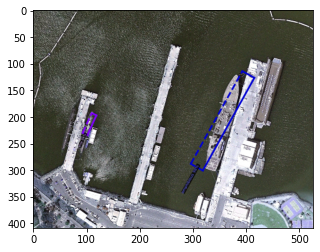

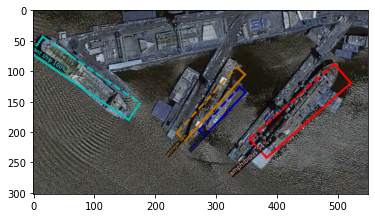

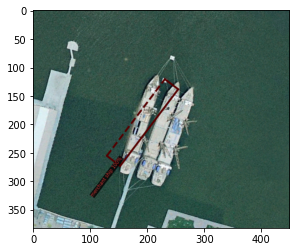

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# predictor = RotatedPredictor(cfg)
predictor = DefaultPredictor(cfg)

test_dict = get_dataset("Test")
for d in random.sample(test_dict, 3):
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
  v = myVisualizer(im[:, :, ::-1],
                  metadata=MetadataCatalog.get("Test"), 
                  scale=0.5)
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  # )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()

